In [249]:
import json
import os
import glob

import os
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [220]:
def load_json_file(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)

def collect_metrics(base_path, metric_name):
    utility_metrics = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file == f"{metric_name}_metrics.json":
                file_path = os.path.join(root, file)
                metrics = load_json_file(file_path)
                utility_metrics.append(metrics)
    return utility_metrics

def compute_means(dicts):
    result = dicts[0].copy()
    for k, v in dicts[0].items():
        if isinstance(v, dict):  # Check if the first element is a dict
            result[k] = compute_means([d[k] for d in dicts])
        else:
            result[k] = np.mean([d[k] for d in dicts])
    return result


In [221]:
models = [
    "TabDDPM", 
    "TabAutoDiff", 
    "StasyAutoDiff", 
    "CTGAN", 
    "Stasy",
    # "MedAutoDiff",
    # "CTABGAN",
    # "AutoGAN",
    ]
random_seed = 0

# Fidelity

In [222]:
fidelity_jsons = dict.fromkeys(models)
for model in models:
    base_dir = f'../results/{model}'
    fidelity_metrics_list = collect_metrics(base_dir, 'fidelity')
    mean_metrics = compute_means(fidelity_metrics_list)
    fidelity_jsons[model] = mean_metrics

In [223]:
fidelity_df = {}
for model, value in fidelity_jsons.items():
    syn = pd.DataFrame(value['syn_df']).reset_index().melt(id_vars='index', value_vars=['wasserstein_distance', 'jensenshannon_distance', 'euclidean_distance'], value_name='syn_df').dropna().set_index(['index', 'variable'])
    holdout = pd.DataFrame(value['holdout_df']).reset_index().melt(id_vars='index', value_vars=['wasserstein_distance', 'jensenshannon_distance', 'euclidean_distance'], value_name='holdout_df').dropna().set_index(['index', 'variable'])
    df = pd.concat([syn, holdout], axis=1)
    df['abs_diff'] = abs(df['syn_df'] - df['holdout_df'])
    fidelity_df[model] = df
fidelity_df = pd.concat(fidelity_df, axis=1)

fidelity_df


TabDDPM  \
                                                              syn_df   
index                              variable                            
visit_prob_per_store               wasserstein_distance     0.750667   
purchase_prob_per_product          wasserstein_distance     0.054761   
basket_size_per_product            wasserstein_distance    11.226417   
time_between_purchase_per_customer wasserstein_distance     9.718360   
customer_retention_per_store       wasserstein_distance     0.203385   
category_penetration_per_category  wasserstein_distance     0.389874   
retail_disc                        wasserstein_distance     6.290451   
coupon_disc                        wasserstein_distance     0.827523   
coupon_match_disc                  wasserstein_distance     0.096238   
revenue                            wasserstein_distance    15.038361   
quantity                           wasserstein_distance    12.172141   
manufacturer_id                    jensenshannon_distance   0.335615   
department                         jensenshannon_distance   0.340547   
brand                              jensenshannon_distance   0.667896   
product_category                   jensenshannon_distance   0.302653   
product_type                       jensenshannon_distance   0.329262   
package_size                       jensenshannon_distance   0.354784   
age                                jensenshannon_distance   0.457778   
income                             jensenshannon_distance   0.295158   
home_ownership                     jensenshannon_distance   0.390661   
marital_status                     jensenshannon_distance   0.513676   
household_size                     jensenshannon_distance   0.350669   
household_comp                     jensenshannon_distance   0.390122   
kids_count                         jensenshannon_distance   0.589371   
pearson_coef                       euclidean_distance       1.296608   
theils_u                           euclidean_distance       4.304366   
correl_ratio                       euclidean_distance       2.121117   

                                                                      \
                                                          holdout_df   
index                              variable                            
visit_prob_per_store               wasserstein_distance     0.003407   
purchase_prob_per_product          wasserstein_distance     0.000503   
basket_size_per_product            wasserstein_distance     0.348000   
time_between_purchase_per_customer wasserstein_distance     0.013092   
customer_retention_per_store       wasserstein_distance     0.000000   
category_penetration_per_category  wasserstein_distance     0.004876   
retail_disc                        wasserstein_distance     0.026817   
coupon_disc                        wasserstein_distance     0.003902   
coupon_match_disc                  wasserstein_distance     0.000335   
revenue                            wasserstein_distance     0.063883   
quantity                           wasserstein_distance     0.026500   
manufacturer_id                    jensenshannon_distance   0.336440   
department                         jensenshannon_distance   0.313143   
brand                              jensenshannon_distance   0.698244   
product_category                   jensenshannon_distance   0.314474   
product_type                       jensenshannon_distance   0.323042   
package_size                       jensenshannon_distance   0.358823   
age                                jensenshannon_distance   0.473487   
income                             jensenshannon_distance   0.290900   
home_ownership                     jensenshannon_distance   0.373480   
marital_status                     jensenshannon_distance   0.576326   
household_size                     jensenshannon_distance   0.325439   
household_comp                     jensenshannon_distance   0.344730   
kids_count                  

## Probability distribution of selected features

In [63]:
numerical_distributions = {}
for model in models:
    with open(f'../results/{model}/{random_seed}/fidelity_info.pkl', 'rb') as f:
        fidelity_info = pickle.load(f)
    numerical_distributions[model] = fidelity_info['syn_df']['numerical']
numerical_distributions['train'] = fidelity_info['train_df']['numerical']
numerical_distributions['holdout'] = fidelity_info['holdout_df']['numerical']


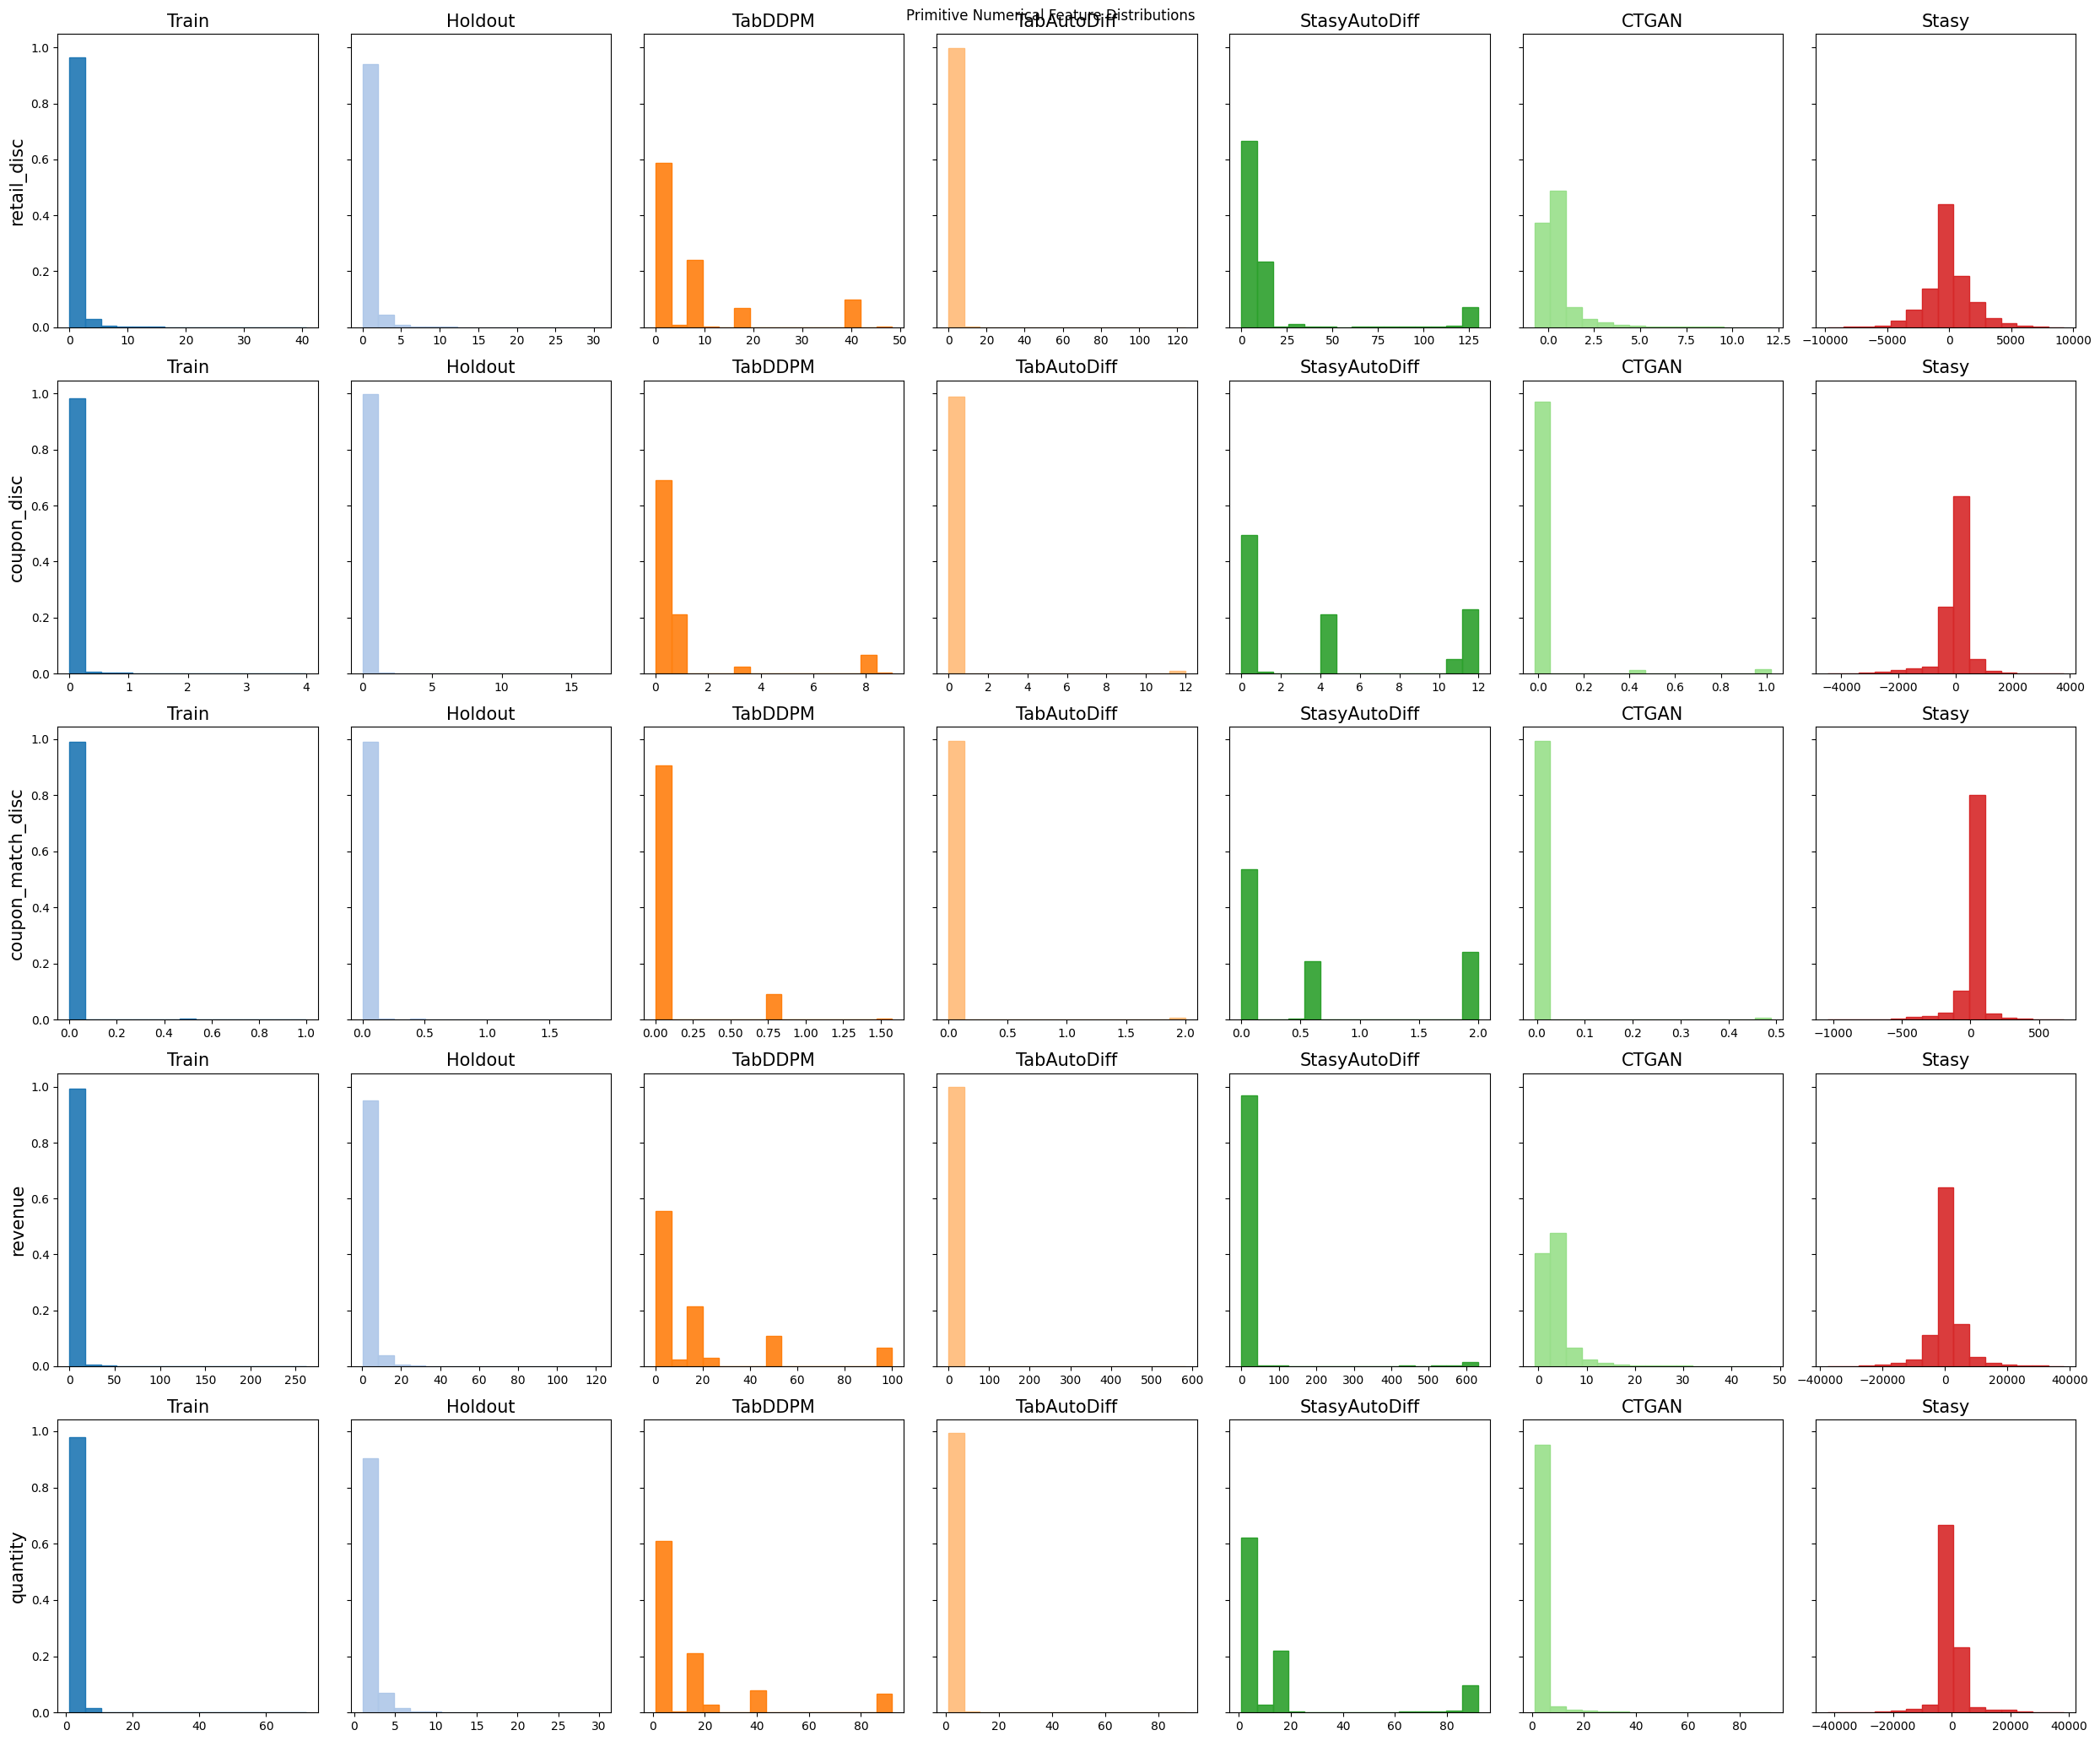

In [252]:
number_features = ['retail_disc',
 'coupon_disc',
 'coupon_match_disc',
 'revenue',
 'quantity']
n_feature = len(number_features)
bins = 15
fontsize=15
n_model = len(numerical_distributions)
colors = sns.color_palette('tab20', n_model)
fig, axes = plt.subplots(nrows=n_feature, ncols=n_model, figsize=(5*n_feature, 3*n_model), sharey='row')#, sharex='row')
for i, feature in enumerate(number_features):
    xmin = numerical_distributions['train'][feature].min()
    xmax = numerical_distributions['train'][feature].max()
    sns.histplot(numerical_distributions['train'][feature], ax=axes[i, 0], color=colors[0], edgecolor=colors[0], label='train', stat='probability', bins=bins, alpha=0.9)
    axes[i, 0].set_title('Train', fontsize=fontsize)
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel(feature, fontsize=fontsize)
    sns.histplot(numerical_distributions['holdout'][feature], ax=axes[i, 1], color=colors[1], edgecolor=colors[1], label='holdout', stat='probability', bins=bins, alpha=0.9)
    axes[i, 1].set_title('Holdout', fontsize=fontsize)
    axes[i, 1].set_xlabel('')
    for j, model in enumerate(models):
        sns.histplot(numerical_distributions[model][feature], ax=axes[i, j+2], color=colors[j+2], edgecolor=colors[j+2], label=model, stat='probability', bins=bins, alpha=0.9)
        axes[i, j+2].set_xlabel('')
        axes[i, j+2].set_title(model, fontsize=fontsize)

fig.suptitle('Primitive Numerical Feature Distributions')
plt.tight_layout()

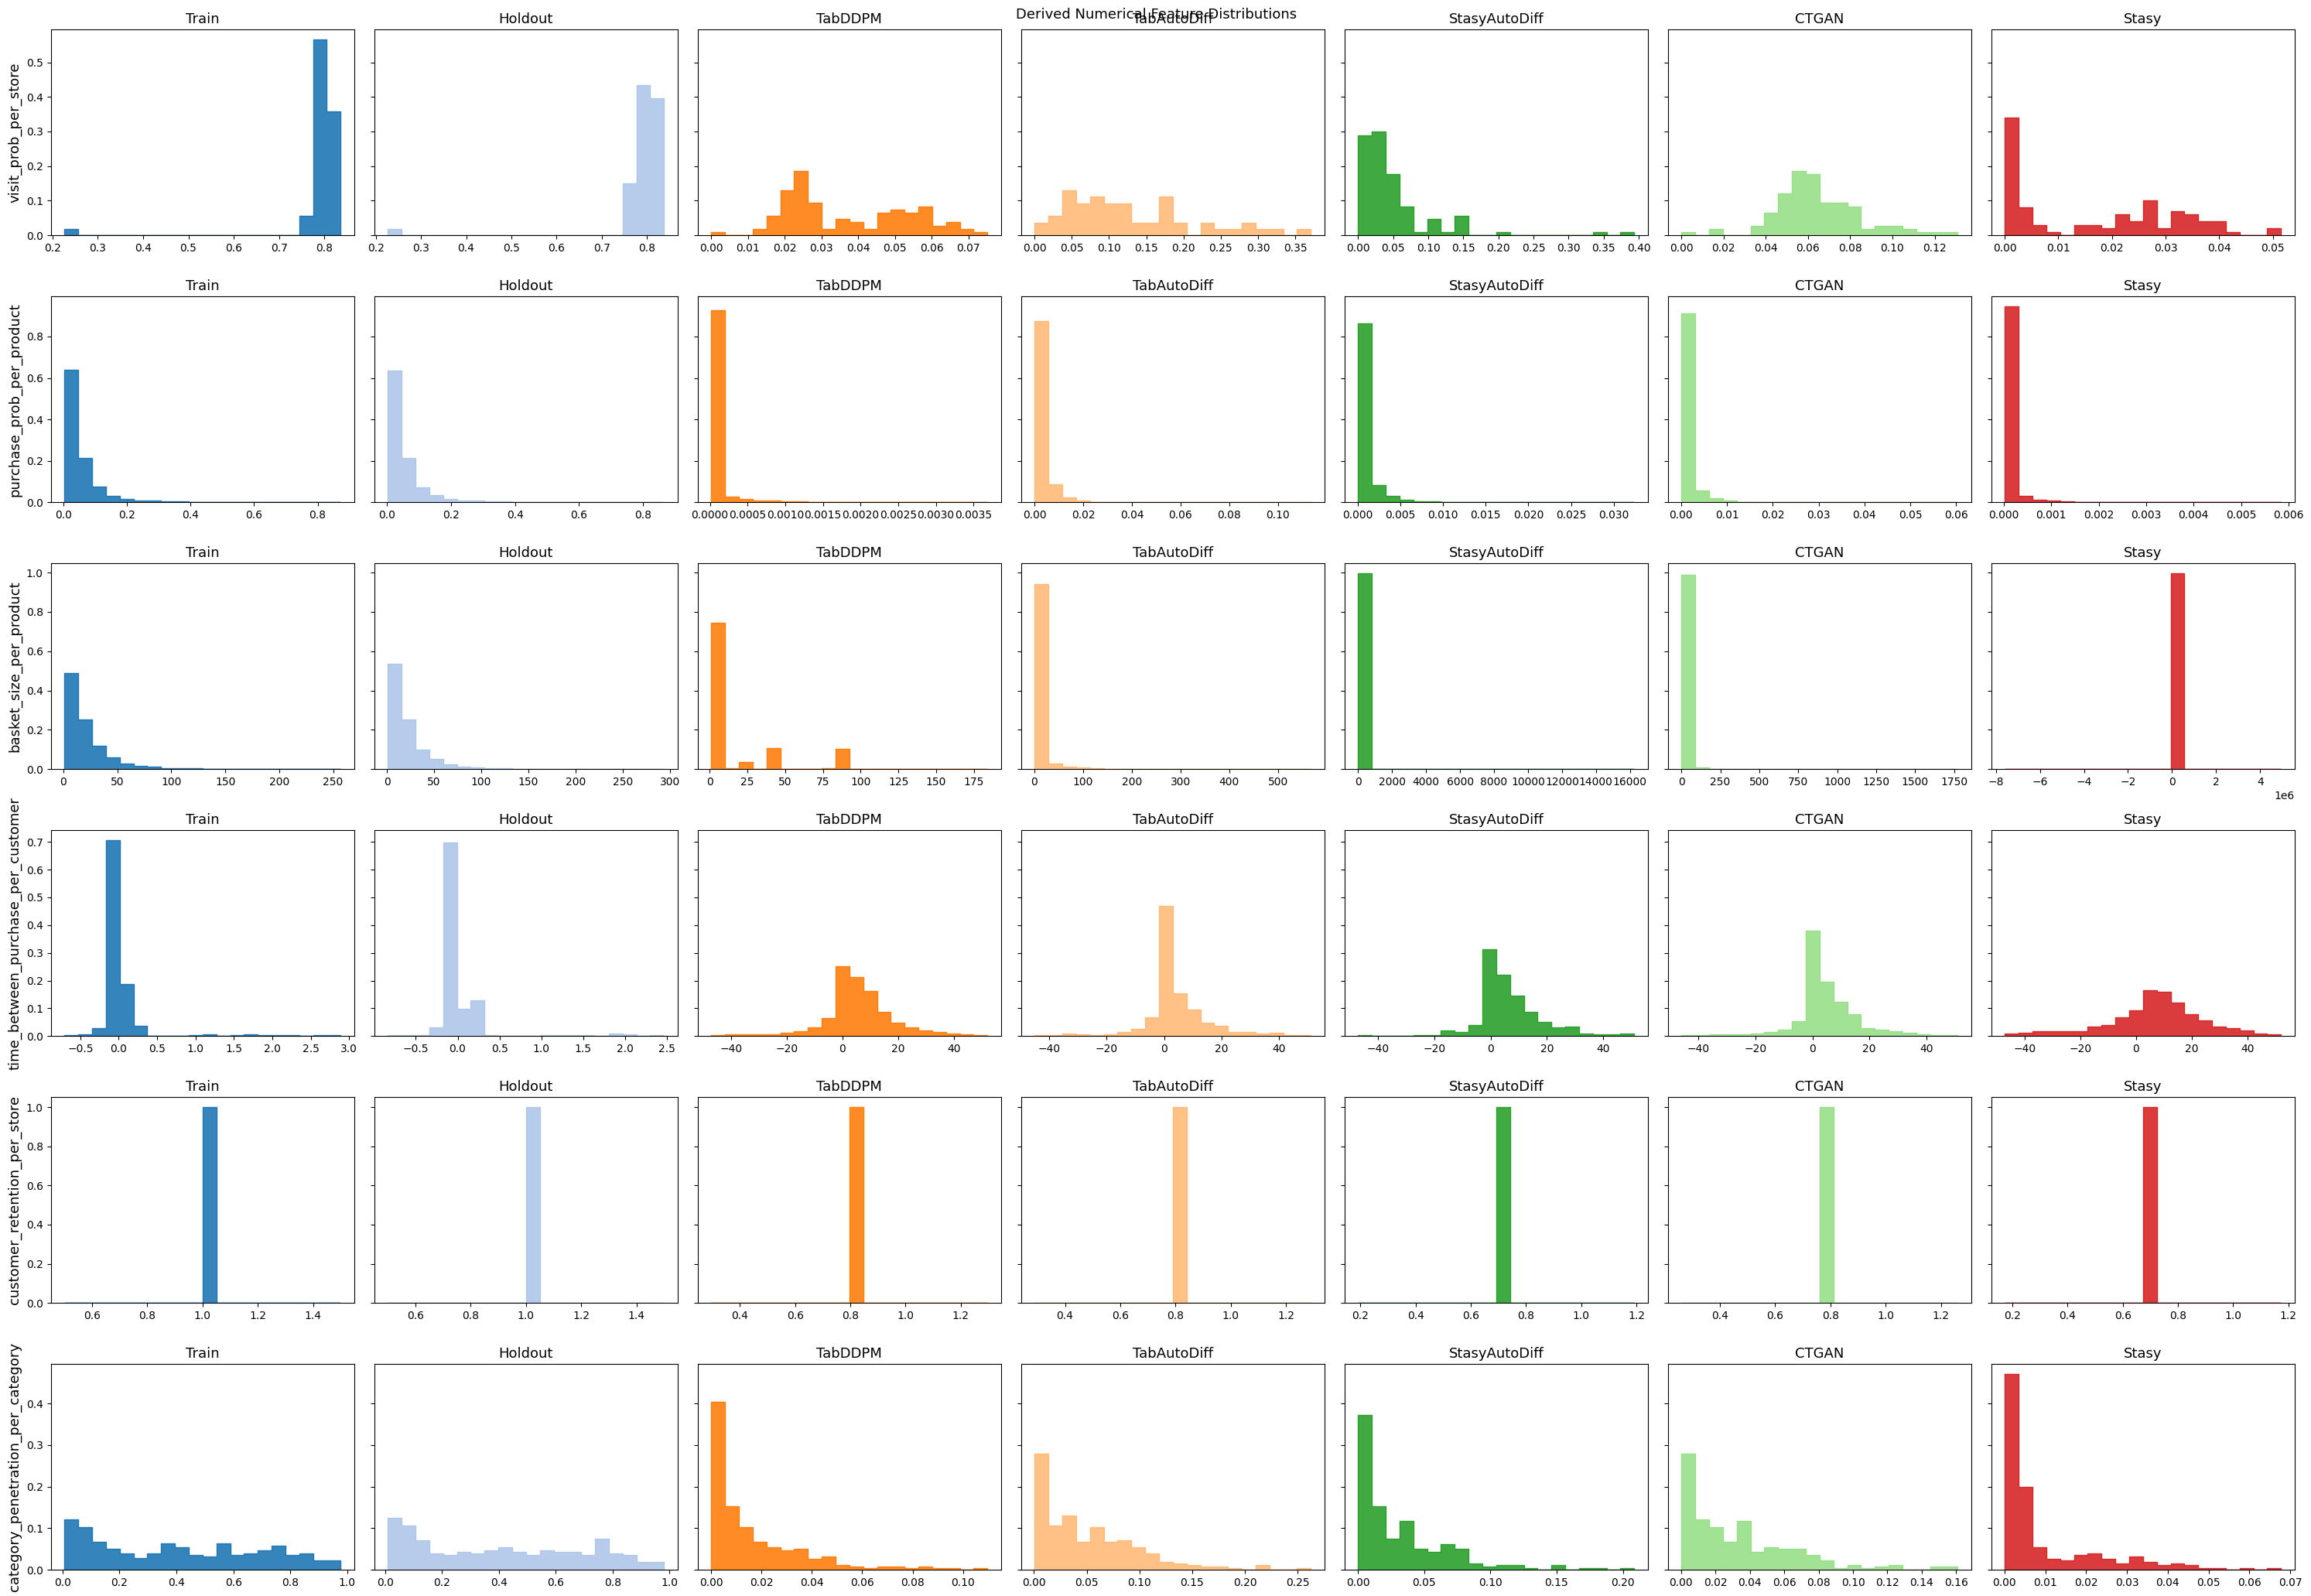

In [253]:
derived_features = ['visit_prob_per_store',
 'purchase_prob_per_product',
 'basket_size_per_product',
 'time_between_purchase_per_customer',
 'customer_retention_per_store',
 'category_penetration_per_category']
n_feature = len(derived_features)
bins = 20
n_model = len(numerical_distributions)
colors = sns.color_palette('tab20', n_model)
fontsize = 13
fig, axes = plt.subplots(nrows=n_feature, ncols=n_model, figsize=(5*n_feature, 3*n_model), sharey='row')#, sharex='row')
for i, feature in enumerate(derived_features):
    sns.histplot(numerical_distributions['train'][feature], ax=axes[i, 0], color=colors[0], edgecolor=colors[0], element='step', label='train', stat='probability', bins=bins, alpha=0.9)
    axes[i, 0].set_title('Train', fontsize=fontsize)
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel(feature, fontsize=fontsize)
    sns.histplot(numerical_distributions['holdout'][feature], ax=axes[i, 1], color=colors[1], element='step', label='holdout', stat='probability', bins=bins, alpha=0.9)
    axes[i, 1].set_title('Holdout', fontsize=fontsize)
    axes[i, 1].set_xlabel('')
    for j, model in enumerate(models):
        sns.histplot(numerical_distributions[model][feature], ax=axes[i, j+2], color=colors[j+2], edgecolor=colors[j+2], element='step', label=model, stat='probability', bins=bins, alpha=0.9)
        axes[i, j+2].set_xlabel('')
        axes[i, j+2].set_title(model, fontsize=fontsize)
fig.suptitle('Derived Numerical Feature Distributions', fontsize=fontsize)
plt.tight_layout()

In [201]:
categorical_distributions = {}
for model in models:
    with open(f'../results/{model}/{random_seed}/fidelity_info.pkl', 'rb') as f:
        fidelity_info = pickle.load(f)
    categorical_distributions[model] = fidelity_info['syn_df']['categorical']
categorical_distributions['train'] = fidelity_info['train_df']['categorical']
categorical_distributions['holdout'] = fidelity_info['holdout_df']['categorical']


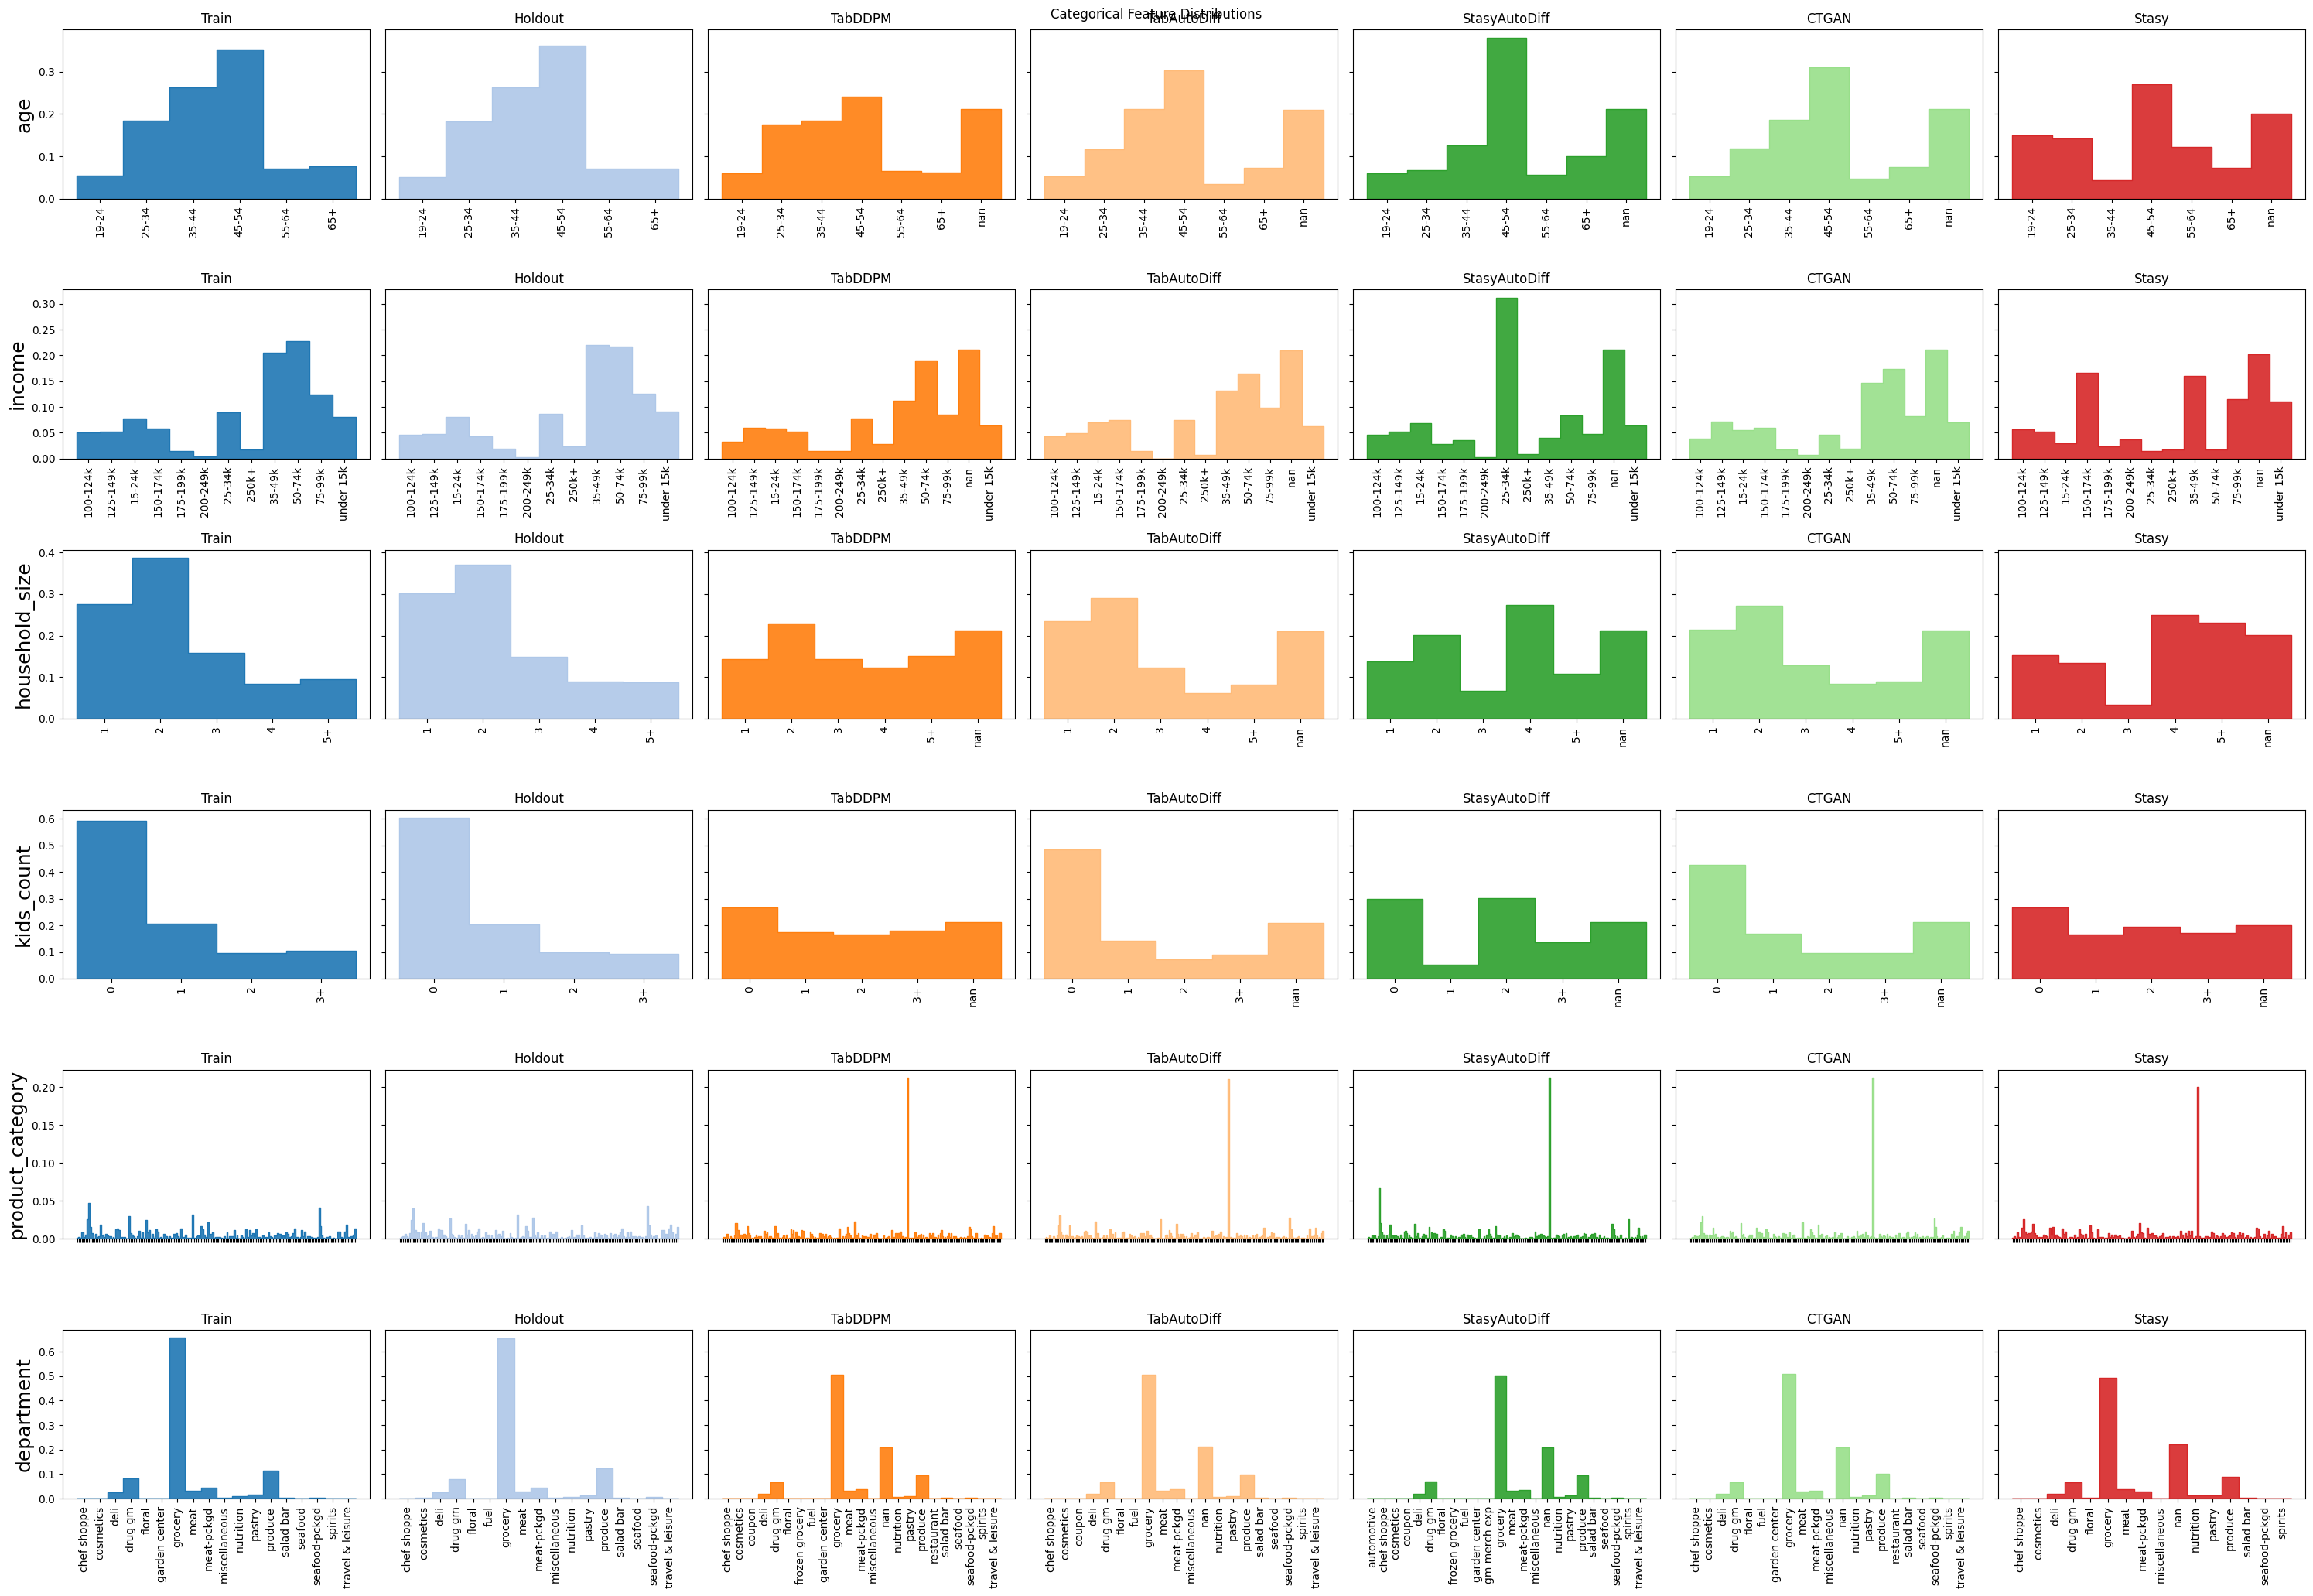

In [255]:
derived_features = ['age', 'income', 'household_size', 'kids_count', 'product_category', 'department']
n_feature = len(derived_features)
bins = 20
n_model = len(categorical_distributions)
colors = sns.color_palette('tab20', n_model)
fontsize = 18
fig, axes = plt.subplots(nrows=n_feature, ncols=n_model, figsize=(5*n_feature, 3*n_model), sharey='row')#, sharex='row')
for i, feature in enumerate(derived_features):
    sns.histplot(categorical_distributions['train'][feature].sort_values(), ax=axes[i, 0], color=colors[0], edgecolor=colors[0], element='step', label='train', stat='probability', bins=bins, alpha=0.9)
    axes[i, 0].set_title('Train')
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel(feature, fontsize=fontsize)
    sns.histplot(categorical_distributions['holdout'][feature].sort_values(), ax=axes[i, 1], color=colors[1], element='step', label='holdout', stat='probability', bins=bins, alpha=0.9)
    axes[i, 1].set_title('Holdout')
    axes[i, 1].set_xlabel('')
    for j, model in enumerate(models):
        sns.histplot(categorical_distributions[model][feature].sort_values(), ax=axes[i, j+2], color=colors[j+2], edgecolor=colors[j+2], element='step', label=model, stat='probability', bins=bins, alpha=0.9)
        axes[i, j+2].set_xlabel('')
        axes[i, j+2].set_title(model)
    if i != n_feature-2:
        for ax in axes[i]:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    else:
        for ax in axes[i]:
            ax.set_xticklabels([], rotation=90)

fig.suptitle('Categorical Feature Distributions')
plt.tight_layout()

## Distribution difference of selected features compared to train data

In [203]:
def get_diff(df1, df2, xmin, xmax, n_bin):
    bins = np.linspace(xmin, xmax, n_bin)
    df1_hist, bin_edge = np.histogram(df1, bins=bins, density=False)
    df2_hist, _ = np.histogram(df2, bins=bins)
    diff = pd.DataFrame(df1_hist / df1_hist.sum() - df2_hist / df2_hist.sum(), columns=['diff'])
    diff['edge'] = bin_edge[:-1]
    return diff

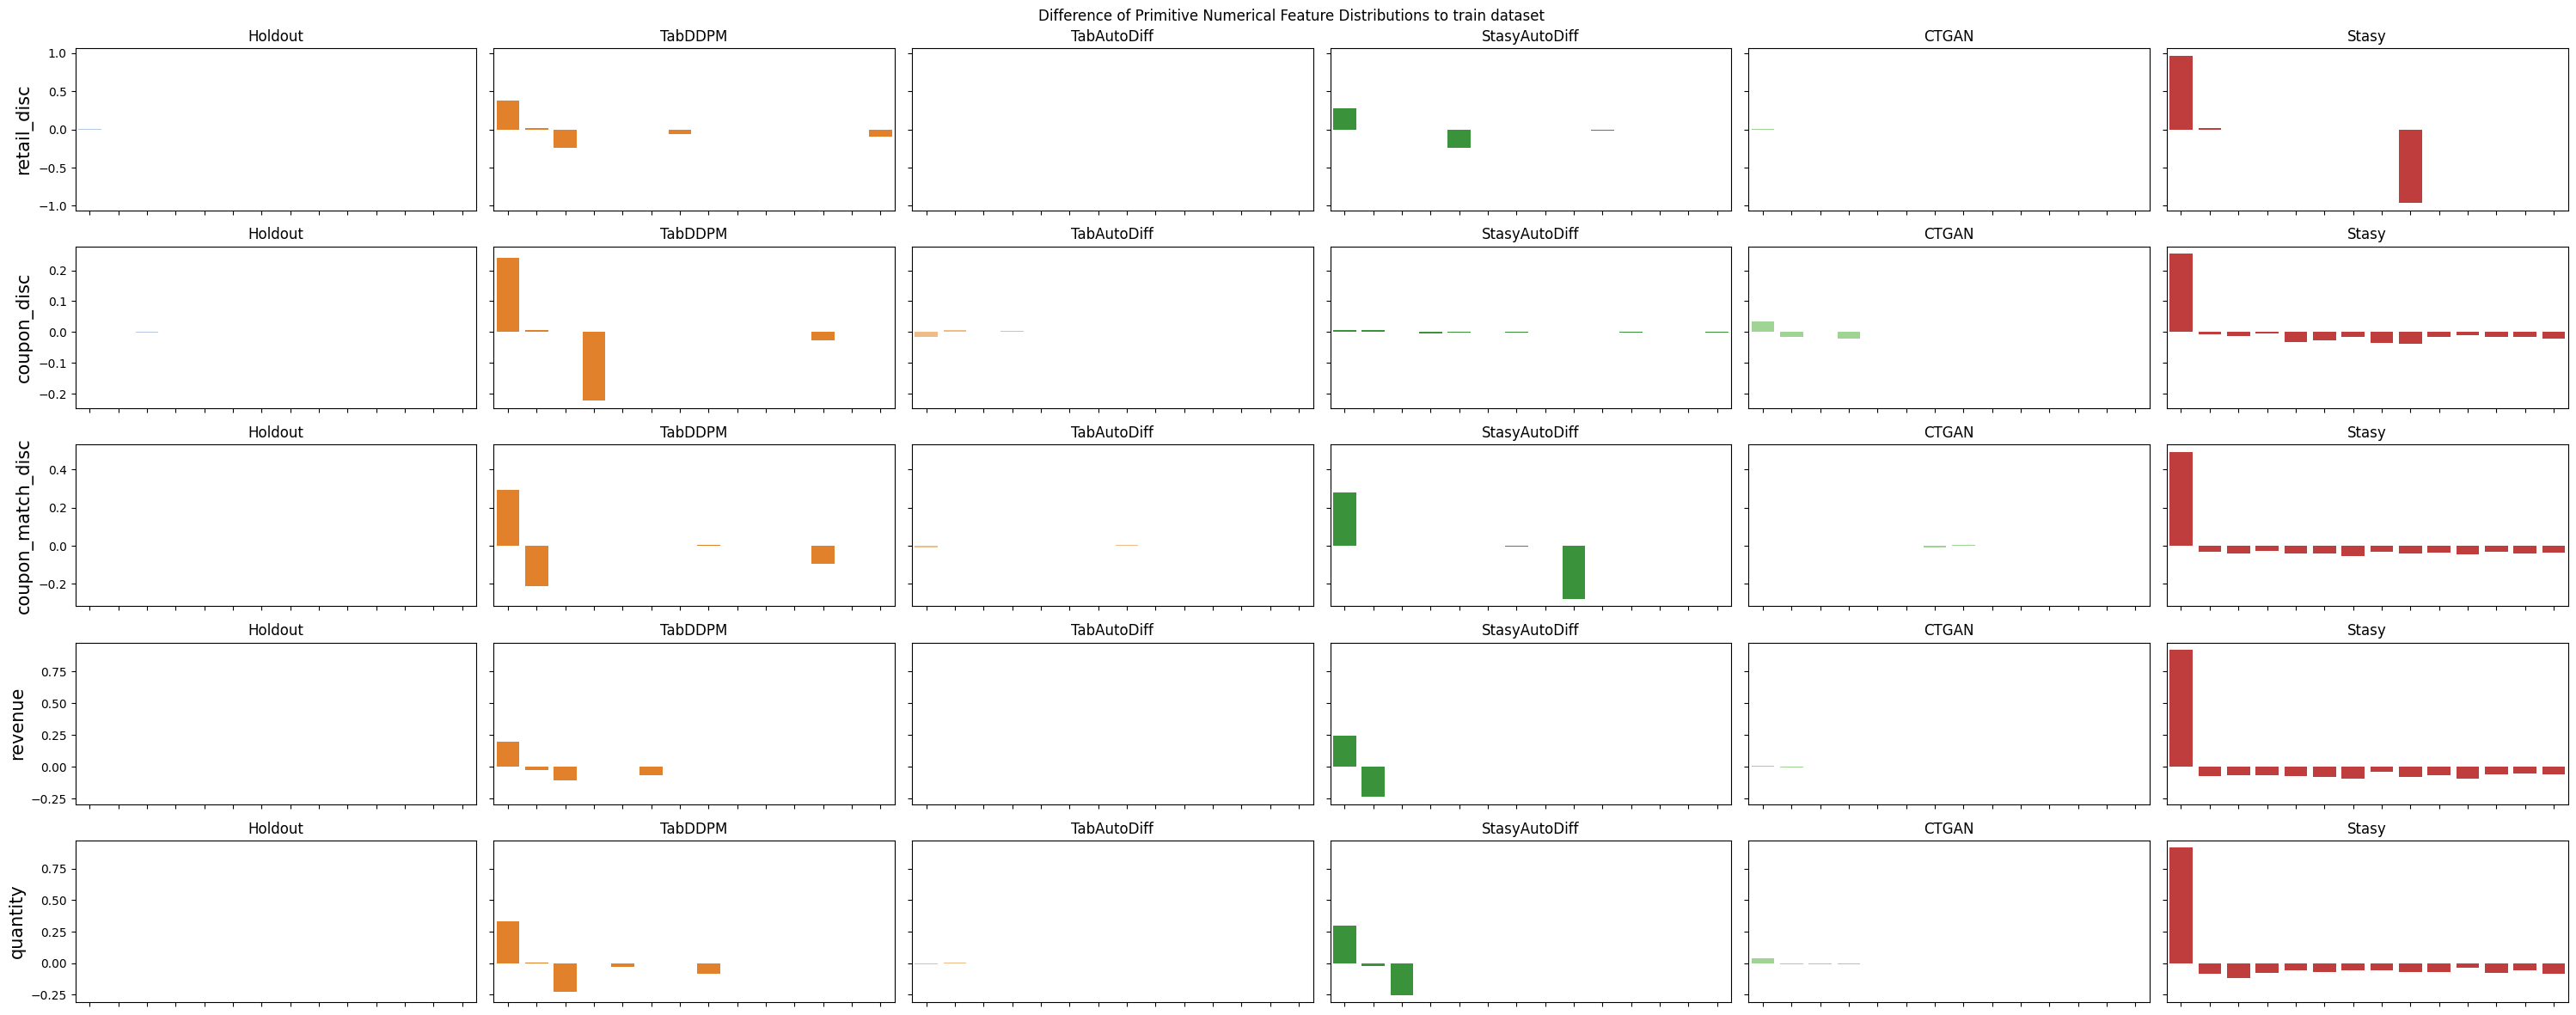

In [257]:
number_features = ['retail_disc',
 'coupon_disc',
 'coupon_match_disc',
 'revenue',
 'quantity']
n_feature = len(number_features)
bins = 15
alpha = 1
fontsize=15
n_model = len(numerical_distributions) - 1
colors = sns.color_palette('tab20', n_model+1)
fig, axes = plt.subplots(nrows=n_feature, ncols=n_model, figsize=(6*n_feature, 2*n_model), sharey='row')
for i, feature in enumerate(number_features):
    xmin = numerical_distributions['train'][feature].min()
    xmax = numerical_distributions['train'][feature].max()
    diff = get_diff(numerical_distributions['train'][feature], numerical_distributions['holdout'][feature], xmin, xmax, bins)
    sns.barplot(data=diff, x='edge', y='diff', ax=axes[i, 0], color=colors[1], alpha=alpha)
    axes[i, 0].set_xticklabels([])
    axes[i, 0].set_title('Holdout')
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel(feature, fontsize=fontsize)
    for j, model in enumerate(models):
        diff = get_diff(numerical_distributions['train'][feature], numerical_distributions[model][feature], xmin, xmax, bins)
        sns.barplot(data=diff, x='edge', y='diff', ax=axes[i, j+1], color=colors[j+2], alpha=alpha)
        axes[i, j+1].set_xticklabels([])
        axes[i, j+1].set_xlabel('')
        axes[i, j+1].set_ylabel('')
        axes[i, j+1].set_xlabel('')
        axes[i, j+1].set_title(model)
    
fig.suptitle('Difference of Primitive Numerical Feature Distributions to train dataset')
plt.tight_layout()

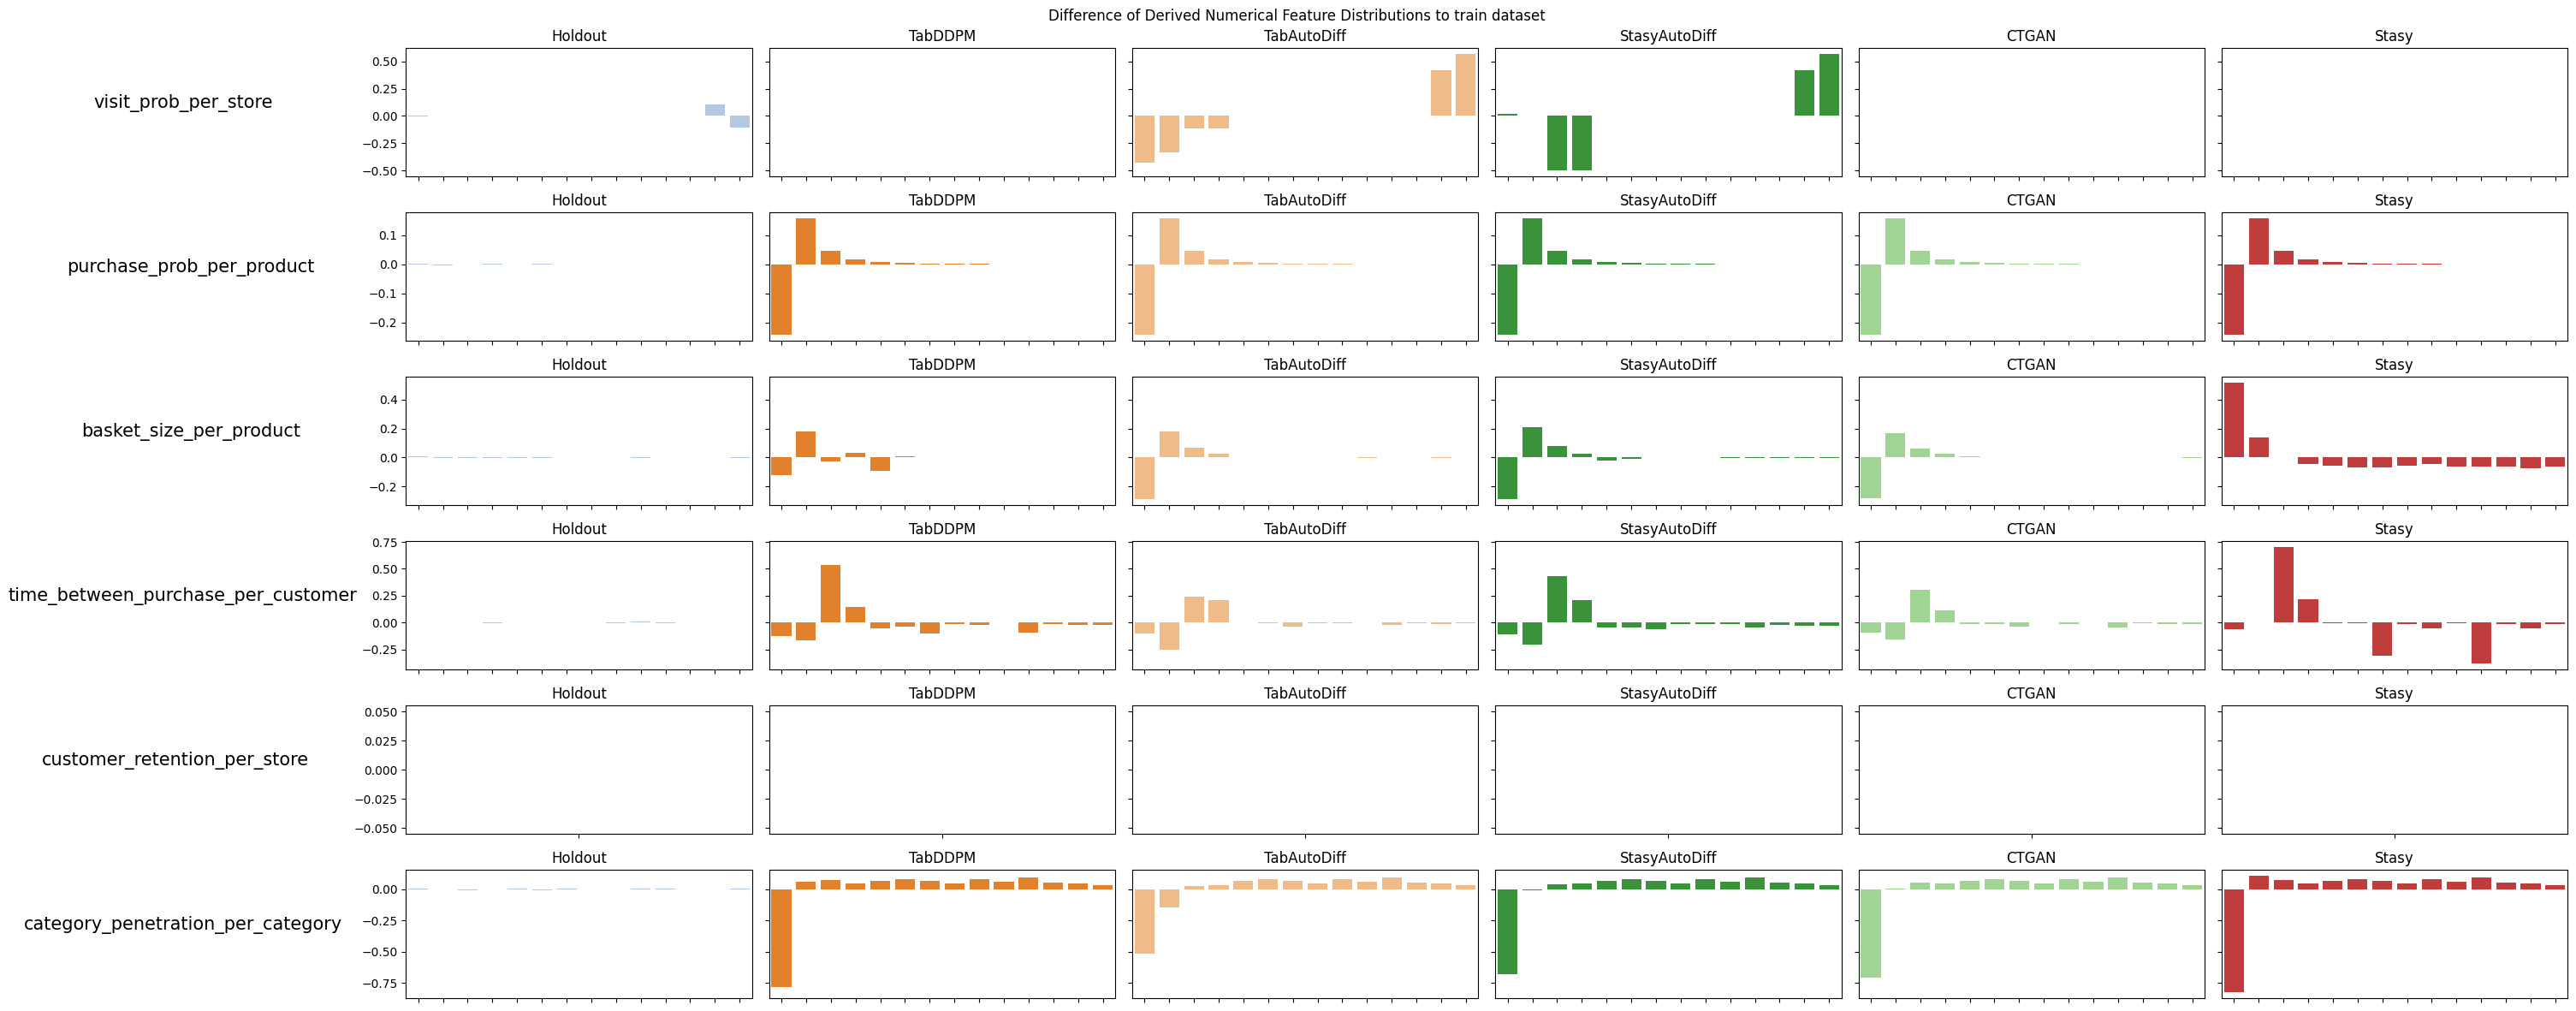

In [265]:
number_features = ['visit_prob_per_store',
 'purchase_prob_per_product',
 'basket_size_per_product',
 'time_between_purchase_per_customer',
 'customer_retention_per_store',
 'category_penetration_per_category']
n_feature = len(number_features)
bins = 15
alpha = 1
n_model = len(numerical_distributions) - 1
fontsize = 15
colors = sns.color_palette('tab20', n_model+1)
fig, axes = plt.subplots(nrows=n_feature, ncols=n_model, figsize=(5*n_feature, 2*n_model), sharey='row')
for i, feature in enumerate(number_features):
    xmin = numerical_distributions['train'][feature].min()
    xmax = numerical_distributions['train'][feature].max()
    diff = get_diff(numerical_distributions['train'][feature], numerical_distributions['holdout'][feature], xmin, xmax, bins)
    sns.barplot(data=diff, x='edge', y='diff', ax=axes[i, 0], color=colors[1], alpha=alpha)
    axes[i, 0].set_xticklabels([])
    axes[i, 0].set_title('Holdout')
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel(feature, fontsize=fontsize, rotation=0, labelpad=150)
    for j, model in enumerate(models):
        diff = get_diff(numerical_distributions['train'][feature], numerical_distributions[model][feature], xmin, xmax, bins)
        sns.barplot(data=diff, x='edge', y='diff', ax=axes[i, j+1], color=colors[j+2], alpha=alpha)
        axes[i, j+1].set_xticklabels([])
        axes[i, j+1].set_xlabel('')
        axes[i, j+1].set_ylabel('')
        axes[i, j+1].set_xlabel('')
        axes[i, j+1].set_title(model)
    
fig.suptitle('Difference of Derived Numerical Feature Distributions to train dataset')
plt.tight_layout()

In [211]:
def get_categorical_diff(df1, df2, column):
    df1_hist = df1.to_frame().groupby(column).size() / len(df1)
    df2_hist = df2.to_frame().groupby(column).size() / len(df2)
    diff = pd.DataFrame(df1_hist - df2_hist, columns=['diff']).sort_index().reset_index()
    return diff


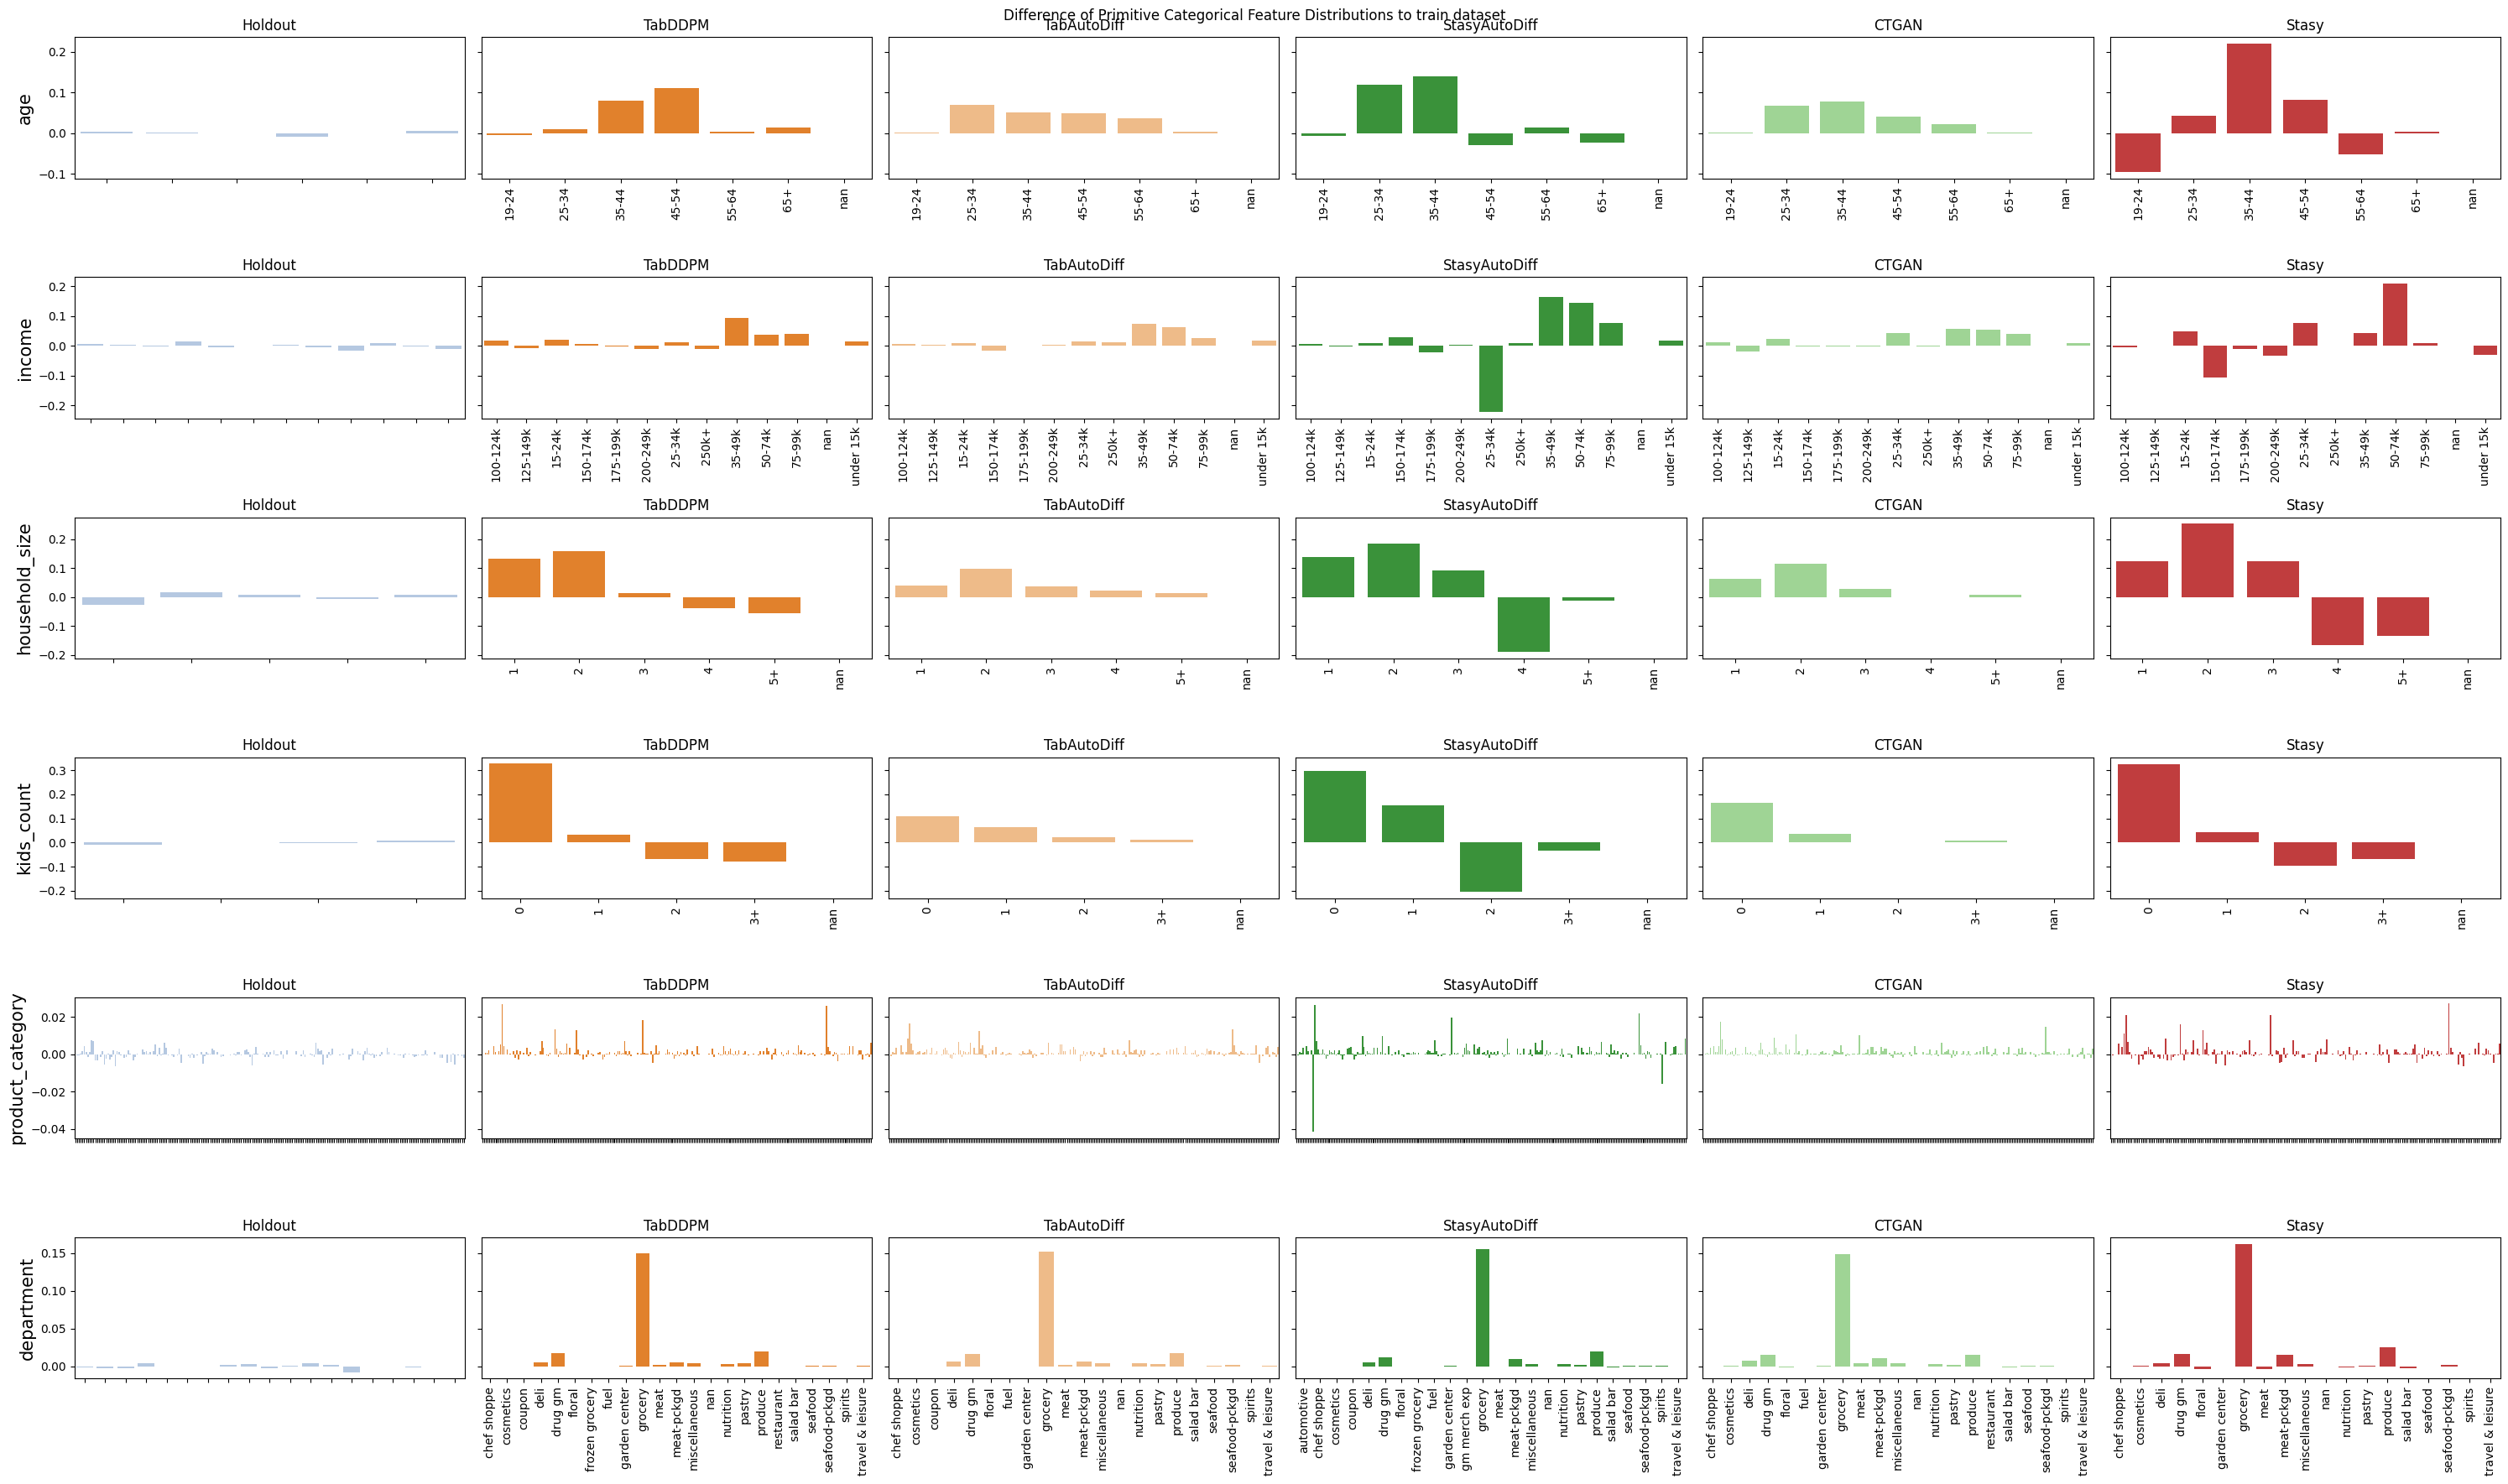

In [261]:
number_features = ['age', 'income', 'household_size', 'kids_count', 'product_category', 'department']
n_feature = len(number_features)
bins = 15
alpha = 1
fontsize = 15
n_model = len(categorical_distributions) - 1
colors = sns.color_palette('tab20', n_model+1)
fontsize = 15
fig, axes = plt.subplots(nrows=n_feature, ncols=n_model, figsize=(5*n_feature, 3*n_model), sharey='row')
for i, feature in enumerate(number_features):
    xmin = categorical_distributions['train'][feature].min()
    xmax = categorical_distributions['train'][feature].max()
    diff = get_categorical_diff(categorical_distributions['train'][feature], categorical_distributions['holdout'][feature], feature)
    sns.barplot(data=diff, x=feature, y='diff', ax=axes[i, 0], color=colors[1], alpha=alpha)
    axes[i, 0].set_xticklabels([])
    axes[i, 0].set_title('Holdout')
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel(feature, fontsize=fontsize)
    for j, model in enumerate(models):
        diff = get_categorical_diff(categorical_distributions['train'][feature], categorical_distributions[model][feature], feature)
        sns.barplot(data=diff, x=feature, y='diff', ax=axes[i, j+1], color=colors[j+2], alpha=alpha)
        if i != n_feature-2:
            for ax in axes[i]:
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        else:
            for ax in axes[i]:
                ax.set_xticklabels([], rotation=90)
        axes[i, j+1].set_xlabel('')
        axes[i, j+1].set_ylabel('')
        axes[i, j+1].set_xlabel('')
        axes[i, j+1].set_title(model)
    
fig.suptitle('Difference of Primitive Categorical Feature Distributions to train dataset')
plt.tight_layout()

## Distribution similarity of categorical columns VS number of unique values

In [224]:
with open(f'../results/TabAutoDiff/{random_seed}/fidelity_info.pkl', 'rb') as f:
    fidelity_info = pickle.load(f)
    categorical_nunique = fidelity_info['train_df']['categorical_feature_nunique']

Text(0.5, 0.98, 'Jensen-Shannon Distance vs. Number of Unique values in the group')

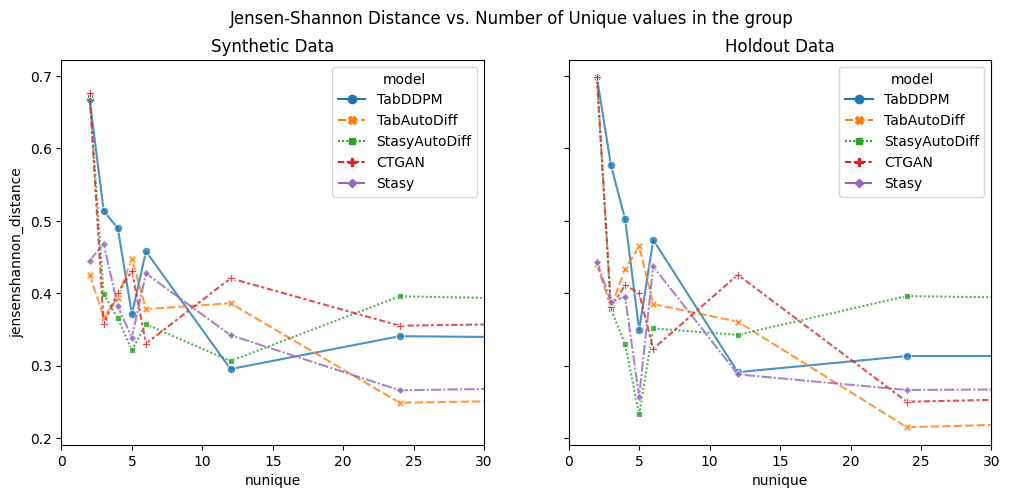

In [248]:
categorical_nunique_df = pd.DataFrame(categorical_nunique.values(), columns=['nunique'], index=categorical_nunique.keys())
syn_df = []
holdout_df = []
for model_name, info in fidelity_jsons.items():
    syn_info_df = pd.DataFrame(info['syn_df']['jensenshannon_distance'].values(), columns=['jensenshannon_distance'], index=info['syn_df']['jensenshannon_distance'].keys())
    syn_info_df['model'] = model_name
    syn_df.append(syn_info_df.merge(categorical_nunique_df, left_index=True, right_index=True))
    holdout_info_df = pd.DataFrame(info['holdout_df']['jensenshannon_distance'].values(), columns=['jensenshannon_distance'], index=info['holdout_df']['jensenshannon_distance'].keys())
    holdout_info_df['model'] = model_name
    holdout_df.append(holdout_info_df.merge(categorical_nunique_df, left_index=True, right_index=True))

syn_df = pd.concat(syn_df).reset_index()
holdout_df = pd.concat(holdout_df).reset_index()

# plotting code
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)
sns.lineplot(data=syn_df, x='nunique', y='jensenshannon_distance', hue='model', ax=ax1, alpha=0.8, markers=True, style='model', errorbar=None)
sns.lineplot(data=holdout_df, x='nunique', y='jensenshannon_distance', hue='model', ax=ax2, alpha=0.8, markers=True, style='model', errorbar=None)
ax1.set_xlim(0, 30)
ax1.set_title('Synthetic Data')
ax2.set_title('Holdout Data') 
fig.suptitle('Jensen-Shannon Distance vs. Number of Unique values in the group')

Text(0.5, 1.0, 'Holdout Data')

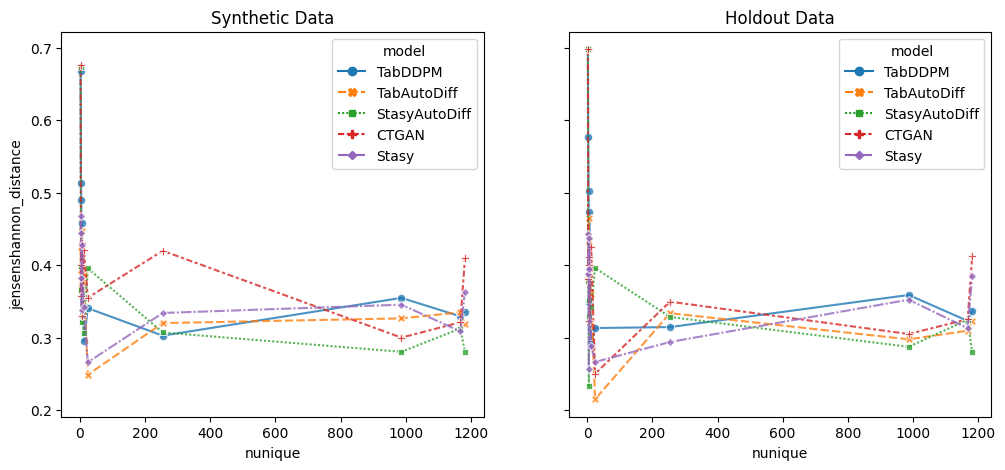

In [247]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)
sns.lineplot(data=syn_df, x='nunique', y='jensenshannon_distance', hue='model', ax=ax1, alpha=0.8, markers=True, style='model', errorbar=None)
sns.lineplot(data=holdout_df, x='nunique', y='jensenshannon_distance', hue='model', ax=ax2, alpha=0.8, markers=True, style='model', errorbar=None)
ax1.set_title('Synthetic Data')
ax2.set_title('Holdout Data') 

# Utility

## Metrics on classification task and corresponding metric difference compared to train data
Every data set is trained on `BaggingClassifier`.

In [47]:
utility_jsons = dict.fromkeys(models)
for model in models:
    base_dir = f'../results/{model}'
    utility_metrics_list = collect_metrics(base_dir, 'utility')
    mean_metrics = compute_means(utility_metrics_list)
    utility_jsons[model] = mean_metrics

In [55]:
# classification metrics
classification_df = []
for model, value in utility_jsons.items():
    df = pd.DataFrame(value['classification']).T
    df['model'] = model
    classification_df.append(df.reset_index())
classification_df = pd.concat(classification_df)
diff = classification_df.groupby('model').transform(lambda x: x - x.iloc[0])
diff.columns = [f'{col}_diff' for col in diff.columns]
classification_df = pd.concat([classification_df, diff], axis=1)
classification_df

/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_21928/3585043413.py:8: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  diff = classification_df.groupby('model').transform(lambda x: x - x.iloc[0])


,index,accuracy,f1,roc,precision,recall,model,accuracy_diff,f1_diff,roc_diff,precision_diff,recall_diff
0,train_df,0.654979,0.621325,0.678236,0.522142,0.767025,TabDDPM,0.000000,0.000000,0.000000,0.000000,0.000000
1,holdout_df,0.656339,0.622989,0.679813,0.523379,0.769428,TabDDPM,0.001360,0.001664,0.001577,0.001237,0.002403
2,syn_df,0.631918,0.092169,0.511260,0.512987,0.050633,TabDDPM,-0.023061,-0.529157,-0.166977,-0.009155,-0.716392
0,train_df,0.654920,0.620447,0.677624,0.522167,0.764301,TabAutoDiff,0.000000,0.000000,0.000000,0.000000,0.000000
1,holdout_df,0.654447,0.623259,0.679378,0.521411,0.774555,TabAutoDiff,-0.000473,0.002812,0.001754,-0.000757,0.010255
2,syn_df,0.677093,0.500868,0.627678,0.582979,0.439032,TabAutoDiff,0.022174,-0.119579,-0.049946,0.060811,-0.325268
0,train_df,0.653855,0.620855,0.677546,0.521035,0.767986,StasyAutoDiff,0.000000,0.000000,0.000000,0.000000,0.000000
1,holdout_df,0.656339,0.623575,0.680212,0.523318,0.771351,StasyAutoDiff,0.002483,0.002720,0.002666,0.002283,0.003365
2,syn_df,0.621038,0.135671,0.508858,0.428450,0.080596,StasyAutoDiff,-0.032817,-0.485184,-0.168688,-0.092585,-0.687390
0,train_df,0.655629,0.622162,0.679018,0.522730,0.768306,CTGAN,0.000000,0.000000,0.000000,0.000000,0.000000


## Metrics on regression task and corresponding metric difference compared to train data
Every data set is trained on `PoissonRegressor`.

In [56]:
# regression metrics(use Poisson regressor)
regression_df = []
for model, value in utility_jsons.items():
    df = pd.DataFrame(value['regression']).T
    df['model'] = model
    regression_df.append(df.reset_index())
regression_df = pd.concat(regression_df)
diff = regression_df.groupby('model').transform(lambda x: x - x.iloc[0])
diff.columns = [f'{col}_diff' for col in diff.columns]
regression_df = pd.concat([regression_df, diff], axis=1)
regression_df


/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_21928/4271742874.py:8: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  diff = regression_df.groupby('model').transform(lambda x: x - x.iloc[0])


,index,mse,r2,model,mse_diff,r2_diff
0,train_df,2.421934e+02,-0.425567,TabDDPM,0.000000e+00,0.000000
1,holdout_df,2.441633e+02,-0.437162,TabDDPM,1.969912e+00,-0.011595
2,syn_df,2.139947e+02,-0.259587,TabDDPM,-2.819874e+01,0.165980
0,train_df,2.421934e+02,-0.425567,TabAutoDiff,0.000000e+00,0.000000
1,holdout_df,2.441633e+02,-0.437162,TabAutoDiff,1.969912e+00,-0.011595
2,syn_df,1.514332e+02,0.108654,TabAutoDiff,-9.076024e+01,0.534221
0,train_df,2.421934e+02,-0.425567,StasyAutoDiff,0.000000e+00,0.000000
1,holdout_df,2.441633e+02,-0.437162,StasyAutoDiff,1.969912e+00,-0.011595
2,syn_df,1.312502e+04,-76.254775,StasyAutoDiff,1.288283e+04,-75.829208
0,train_df,2.421934e+02,-0.425567,CTGAN,0.000000e+00,0.000000


# Privacy

## DCR

In [76]:
privacy_df = []
for model in models:
    base_dir = f'../results/{model}'
    privacy_metrics_list = collect_metrics(base_dir, 'privacy')
    mean_metrics = compute_means(privacy_metrics_list)
    mean_metrics['model'] = model
    privacy_df.append(mean_metrics)
privacy_df = pd.DataFrame(privacy_df)

privacy_df

,dcr,model
0,22.618683,TabDDPM
1,31.528440,TabAutoDiff
2,27.369472,StasyAutoDiff
3,31.417039,CTGAN
4,113.234550,Stasy


## Ratio of synthetic points closer to train data VS the one closer to holdout data

In [267]:
distance_comparison_df = []
for model in models:
    try:
        distance_comparison = pd.read_csv(f'../results/{model}/{random_seed}/privacy_distance_comparison.csv')
    except:
        continue
    close_to_real = (distance_comparison['distance_to_real'] <= distance_comparison['distance_to_holdout']).sum() / len(distance_comparison)
    close_to_holdout = 1 - close_to_real
    distance_comparison_df.append({'model': model, 'close_to_real': close_to_real, 'close_to_holdout': close_to_holdout})
distance_comparison_df = pd.DataFrame(distance_comparison_df)

distance_comparison_df

,model,close_to_real,close_to_holdout
0,TabDDPM,0.5508,0.4492
1,TabAutoDiff,0.5308,0.4692
2,StasyAutoDiff,0.5096,0.4904
3,CTGAN,0.4990,0.5010
4,Stasy,0.5915,0.4085


# TODO
1. Retrain Stasy model with larger training epochs and evaluate it again.
2. Copy training result of AutoGAN from remote server and evaluate it.
3. Fix the bug in the utility evaluation of Stasy model.